In [1]:
import os
os.chdir('../')

In [23]:
import pandas as pd
from source.lib.helpers import ImputeTimePeriod

In [26]:
df_event_study_panel = pd.read_parquet('issue/event_study_panel.parquet')
df_cov_panel_nyt = pd.read_parquet("issue/nyt_covariate_bins.parquet")
repo_list = df_event_study_panel[df_event_study_panel['treated']]['repo_name'].unique().tolist()
# ultimately reop-filter should be made all repos
repo_filter = [("repo_name", "in", repo_list)]

In [4]:
df_issue = pd.read_parquet('drive/output/derived/data_export/df_issue.parquet', filters = repo_filter)
df_pr = pd.read_parquet('drive/output/derived/data_export/df_pr.parquet', filters = repo_filter).query('created_at.year>=2015')

In [101]:
df_issue = df_issue[df_issue['created_at'].dt.year>=2015]
df_issue = ImputeTimePeriod(df_issue, 6)
unique_times = df_issue['time_period'].drop_duplicates().sort_values().unique()
time_index_map = {t: i + 1 for i, t in enumerate(unique_times)}
df_issue['time_index'] = df_issue['time_period'].map(time_index_map)

/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])
/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['created_at'].dt.year
/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [55]:
df_pr = df_pr[df_pr['created_at'].dt.year>=2015]
df_pr = ImputeTimePeriod(df_pr, 6)
unique_times = df_pr['time_period'].drop_duplicates().sort_values().unique()
time_index_map = {t: i + 1 for i, t in enumerate(unique_times)}
df_pr['time_index'] = df_pr['time_period'].map(time_index_map)

/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])
/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['created_at'].dt.year
/Volumes/cliao_HD/oss_hierarchy/source/lib/helpers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [61]:
df_departed = df_event_study_panel.query('treated==1')[['repo_name','treatment_period']].drop_duplicates()
df_departed = pd.merge(df_departed, df_cov_panel_nyt[['repo_name','mean_cluster_overlap_2p_back_bin_third']].dropna())
df_departed['treatment_index'] = df_departed['treatment_period'].map(time_index_map)

In [77]:
df_pr_opener_merged = pd.merge(df_pr.query('pr_action == "opened"'),
                        df_departed, left_on = ['repo_name'], right_on = ['repo_name'])
df_departed_actor = df_event_study_panel.query('treated==1')[['repo_name','departed_actor_id']].drop_duplicates().assign(departed_open_pr = 1)
df_pr_opener_merged = pd.merge(df_pr_opener_merged, df_departed_actor, left_on = ['repo_name', 'actor_id'], right_on = ['repo_name', 'departed_actor_id'], how = 'left')
df_pr_opener_merged['relative_time'] = df_pr_opener_merged['time_index']-df_pr_opener_merged['treatment_index']
df_pr_opener_merged['departed_open_pr'] = df_pr_opener_merged['departed_open_pr'].fillna(0)

In [114]:
df_issue_commenter_merged = pd.merge(df_issue.query('issue_user_id != actor_id & ~issue_comment_id.isna()').sort_values(['repo_name','issue_number','created_at']),
                        df_departed, left_on = ['repo_name'], right_on = ['repo_name'])
df_departed_actor = df_event_study_panel.query('treated==1')[['repo_name','departed_actor_id']].drop_duplicates().assign(departed_comment = 1)
df_issue_commenter_merged = pd.merge(df_issue_commenter_merged, df_departed_actor, left_on = ['repo_name', 'actor_id'], right_on = ['repo_name', 'departed_actor_id'], how = 'left')
df_issue_commenter_merged['relative_time'] = df_issue_commenter_merged['time_index']-df_issue_commenter_merged['treatment_index']
df_issue_commenter_merged['departed_comment'] = df_issue_commenter_merged['departed_comment'].fillna(0)
df_issue_commenter_merged.sort_values(['repo_name','issue_number','created_at'], inplace = True)

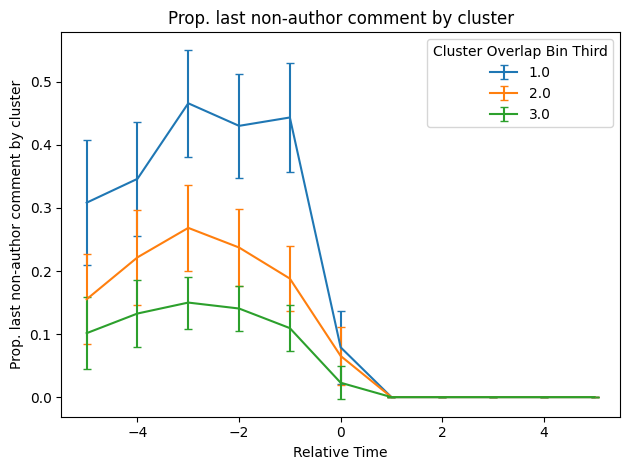

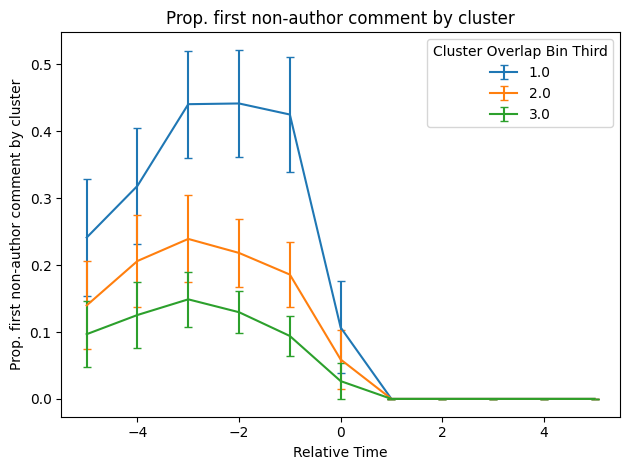

In [116]:
PlotSharePRsOpened(df_issue_commenter_merged.groupby(['repo_name','issue_number'], as_index = False).tail(1),
                   'departed_comment','mean','Prop. last non-author comment by cluster','Prop. last non-author comment by cluster')
PlotSharePRsOpened(df_issue_commenter_merged.groupby(['repo_name','issue_number'], as_index = False).head(1),
                   'departed_comment','mean','Prop. first non-author comment by cluster','Prop. first non-author comment by cluster')

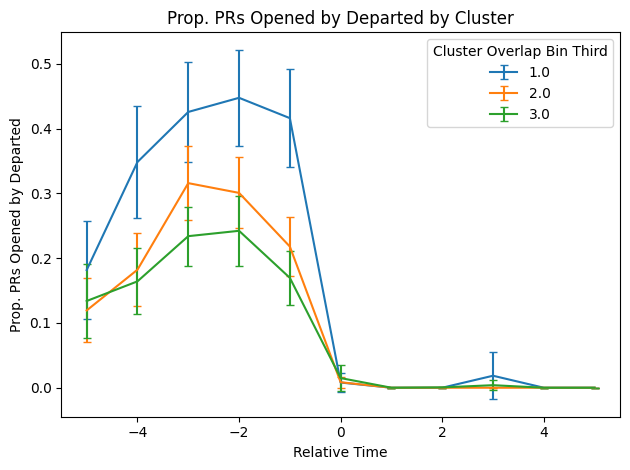

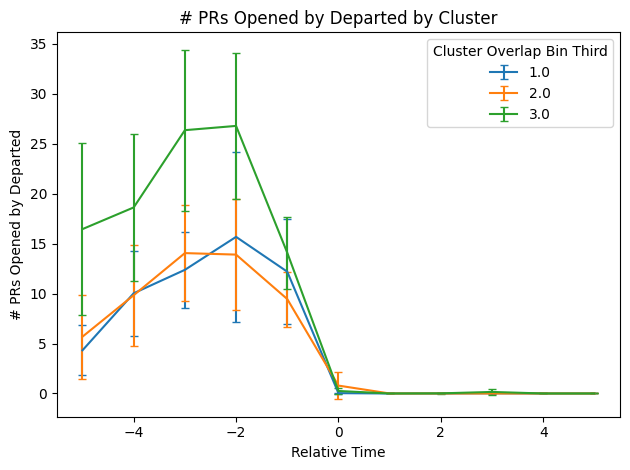

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def PlotSharePRsOpened(df, metric_col, stat, title, yaxis_label):
    df_repo_stats = (
        df.groupby(['relative_time', 'mean_cluster_overlap_2p_back_bin_third','repo_name'])[metric_col].agg(stat).reset_index()
    )
    df_stats = (
        df_repo_stats.groupby(['relative_time', 'mean_cluster_overlap_2p_back_bin_third'])[metric_col]
          .agg(['mean', 'count', 'std'])
          .reset_index()
    )
    df_stats['se'] = 1.96*df_stats['std'] / np.sqrt(df_stats['count'])
    df_stats = df_stats[df_stats['relative_time'].between(-5, 5)]
    df_mean = df_stats.pivot(
        index='relative_time',
        columns='mean_cluster_overlap_2p_back_bin_third',
        values='mean'
    )
    df_se = df_stats.pivot(
        index='relative_time',
        columns='mean_cluster_overlap_2p_back_bin_third',
        values='se'
    )

    plt.figure()
    for bin_value in df_mean.columns:
        plt.errorbar(
            df_mean.index,
            df_mean[bin_value],
            yerr=df_se[bin_value],
            label=str(bin_value),
            capsize=3
        )
    plt.xlabel('Relative Time')
    plt.ylabel(yaxis_label)
    plt.legend(title='Cluster Overlap Bin Third')
    plt.title(title)
    plt.tight_layout()
    plt.show()

PlotSharePRsOpened(df_pr_opener_merged, 'departed_open_pr', 'mean', 'Prop. PRs Opened by Departed by Cluster','Prop. PRs Opened by Departed')
PlotSharePRsOpened(df_pr_opener_merged, 'departed_open_pr', 'sum', '# PRs Opened by Departed by Cluster','# PRs Opened by Departed')

### Measuring Collaboratoin

In [117]:
df_issue

,type,created_at,repo_id,repo_name,actor_id,actor_login,issue_action,issue_title,issue_body,issue_user_id,...,issue_state,issue_comment_id,issue_comment_body,actor_type,latest_issue_labels,latest_issue_assignee,date,year,time_period,time_index
18,IssuesEvent,2017-05-18 05:58:36+00:00,22725061,numba/llvmlite,2505101,GTmAster,opened,Can't install llvmlite 0.18.0 on Windows,Can't install llvmlite via pip on Windows.\r\n...,2505101.0,...,open,NaN,None,None,None,None,2017-5,2017,2017-01-01,5
45,IssuesEvent,2017-05-23 22:12:13+00:00,23335328,signalfx/signalfx-python,16408,somic,opened,Get data to pandas dataframe,This is a nice-to-have.\r\n\r\nWould be great ...,16408.0,...,open,NaN,None,None,None,None,2017-5,2017,2017-01-01,5
59,IssuesEvent,2017-05-16 23:00:32+00:00,7184072,hylang/hy,322730,Kodiologist,closed,`get` raises `name not defined` with toolz lib...,Toolz is a functional programming library that...,4041902.0,...,closed,NaN,None,None,None,None,2017-5,2017,2017-01-01,5
60,IssuesEvent,2017-05-25 13:19:29+00:00,1049095,kivy/kivy,7513068,dessant,closed,Pyinstaller SDL2 error,So the issue I have is that when I compile an ...,1400967.0,...,closed,NaN,None,None,None,None,2017-5,2017,2017-01-01,5
61,IssuesEvent,2017-05-09 20:18:13+00:00,1049095,kivy/kivy,8825439,KeyWeeUsr,closed,Clock stops when a Window is imported,"### Versions\r\n\r\n* Python: 2.7, 3.6\r\n* OS...",8825439.0,...,closed,NaN,None,None,None,None,2017-5,2017,2017-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114161,IssueCommentEvent,2021-03-12 05:31:14+00:00,79083614,python-trio/trio,22429695,codecov[bot],None,None,None,27856297.0,...,None,797245612.0,# [Codecov](https://codecov.io/gh/python-trio/...,Bot,None,None,2021-3,2021,2021-01-01,13
114217,IssueCommentEvent,2021-03-16 17:17:57+00:00,16479108,wagtail/wagtail,29703080,squash-labs[bot],None,None,None,55137073.0,...,None,800454042.0,"<h2>Manage this branch in <a href=""https://app...",Bot,None,None,2021-3,2021,2021-01-01,13
114219,IssueCommentEvent,2021-03-01 02:21:18+00:00,124593057,wemake-services/wemake-python-styleguide,22429695,codecov[bot],None,None,None,27856297.0,...,None,787589651.0,# [Codecov](https://codecov.io/gh/wemake-servi...,Bot,None,None,2021-3,2021,2021-01-01,13
114224,IssueCommentEvent,2021-03-08 12:17:37+00:00,34061246,Sung-Huan/ANNOgesic,6706987,Sung-Huan,None,None,None,52718314.0,...,None,792717965.0,"Dear Stephen,\r\n\r\nDifferent library has dif...",User,None,None,2021-3,2021,2021-01-01,13
